# Compressed Sensing: Application à l'IRM
    GARNIER Rémy (M2 StatML), NGUYEN Dinh-Phong (M2 Data Science)

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from IPython import display
warnings.filterwarnings('ignore')
%matplotlib inline

## Incohérence

On explore l'importance de l'incohérence des vecteurs de mesure. Générons un vecteur $x$ de longueur 100 avec 5 coefficients non-nuls positionnés aléatoirement, représentant un signal quelconque 5-sparse.

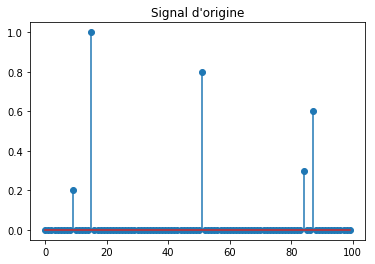

In [39]:
x = np.array([0.2, 0.3, 0.6, 0.8, 1.] + [0] * 95)
np.random.seed(42)
np.random.shuffle(x)
plt.stem(x)
plt.title('Signal d\'origine');

Prenons la transformation de Fourier discrète de ce vecteur, $X = Fx$, où $F$ représente la matrice de Vandermonde-Fourier:

In [40]:
X = np.fft.fft(x)

L'objectif principal du compressed sensing est de pouvoir reconstruire le signal d'origine à partir d'une "information incomplète" (nombre de mesures limité) sur celui-ci. Il est en général impossible de reconstruire $x$ uniquement à partir des coefficients de Fourier car la transformée de Fourier est une bijection de $\mathbb{C}^N$. Néanmoins, si l'on sait que le signal d'origine $x$ est $s$-sparse, on se trouve bien dans le cadre du compressed sensing.

Prenons alors un sous-échantillon $X_u = F_u x$ de $X$, où $F_u$ est une matrice de Vandermonde-Fourier évaluée sur seulement une partie du domaine de fréquences. Nous allons comparer deux cas de sous-échantillonage dans le domaine de Fourier:

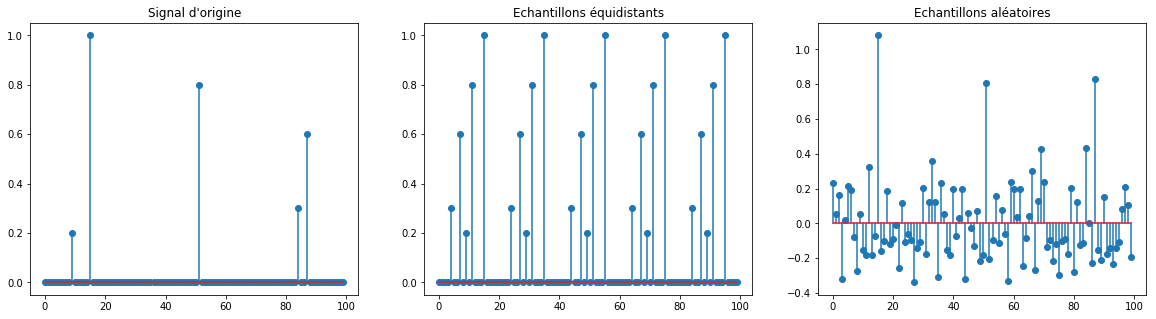

In [41]:
Xu = np.zeros(100, dtype='complex')
Xu[::5] = X[::5]

Xr = np.zeros(100, dtype='complex')
sample_idx = np.random.choice(100, 20)
Xr[sample_idx] = X[sample_idx]

# Transformée inverse
xu = np.fft.ifft(Xu) * 5
xr = np.fft.ifft(Xr) * 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].stem(x)
ax[0].set_title('Signal d\'origine')
ax[1].stem(xu)
ax[1].set_title('Echantillons équidistants')
ax[2].stem(xr)
ax[2].set_title('Echantillons aléatoires');

On peut intuitivement se dire que la reconstruction du signal sera plus facile avec un sous-échantillonnage aléatoire.

## Reconstruction

Nous allons ici faire appel à la procédure de minimisation l1 vue en cours (seuillage doux itératif):
$$\widehat{x} = argmin \|y-\phi x\|^2_{l_2} + \lambda \|\psi x\|_{l_1}$$

où $x$ et $\widehat{x}$ sont le signal d'origine et sa reconstruction respectivement, $\phi$ la matrice d'acquisition du signal, $y$ la donnée observée, $\psi$ la transformation vers le domaine où le signal est sparse et $\lambda$ le paramètre de régularisation.

In [47]:
def SoftThresh(y, t):
    x_hat = (y / np.abs(y)) * np.maximum(np.abs(y)-t, 0)
    return x_hat

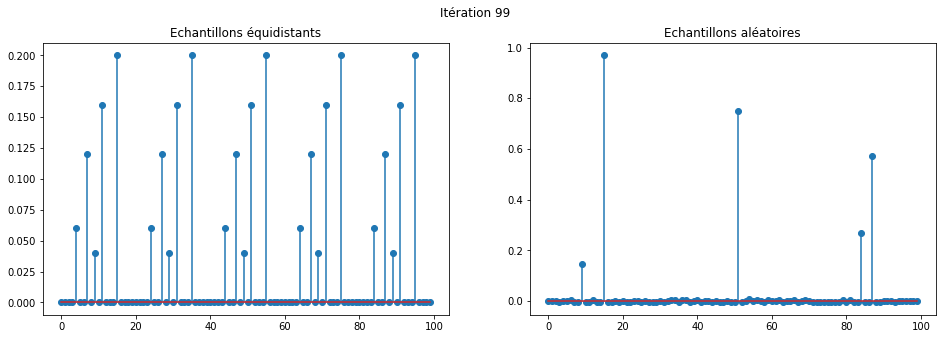

In [43]:
l = 0.01
n_iter = 100

Y1 = Xu # Echantillons équidistants
Y2 = Xr # Echantillons aléatoires
Xi1 = Y1
Xi2 = Y2

for i in range(n_iter):
    xi1 = np.fft.ifft(Xi1) # Transformée de Fourier inverse
    xi1_st = SoftThresh(xi1.real, l) # Seuillage doux
    Xi1 = np.fft.fft(xi1_st) # Transformée de Fourier
    Xi1 = Xi1 * (Y1==0) + Y1
    
    xi2 = np.fft.ifft(Xi2)
    xi2_st = SoftThresh(xi2.real, l)
    Xi2 = np.fft.fft(xi2_st)
    Xi2 = Xi2 * (Y2==0) + Y2
    
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].stem(xi1.real)
    ax[0].set_title('Echantillons équidistants')
    ax[1].stem(xi2.real)
    ax[1].set_title('Echantillons aléatoires')
    plt.suptitle('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

On a donc bien réussi à reconstruire le signal d'origine dans le cas du sous-échantillonnage aléatoire. On remarque que même les coefficients initialement "noyés" dans le bruit ont pu être récupérés.

## Application à l'IRM

En IRM, les données sont acquises directement dans l’espace de Fourier de l’image (et non dans l'espace des pixels), encore appelé $k$-space. On mesure ainsi un ensemble de valeurs de la transformée de Fourier d’une image. L’application du Compressed Sensing en IRM permet de recueillir moins de mesures que préconisé par le critère de Nyquist (chaque oscillation doit être sondée au moins une fois), puis à reconstruire une image grâce à des algorithmes itératifs non-linéaires (comme le seuillage doux itératif). Pour ce faire, les mesures acquises dans le $k$-space doivent être distribuées selon une certaine densité dépendant de la structure de parcimonie du signal d'origine. En pratique, on doit échantillonner de façon plus dense les basses fréquences.

Dans ce qui suit, nous allons donc simuler l'acquisition d'une IRM cérébrale (séquence T2) dans le $k$-space:

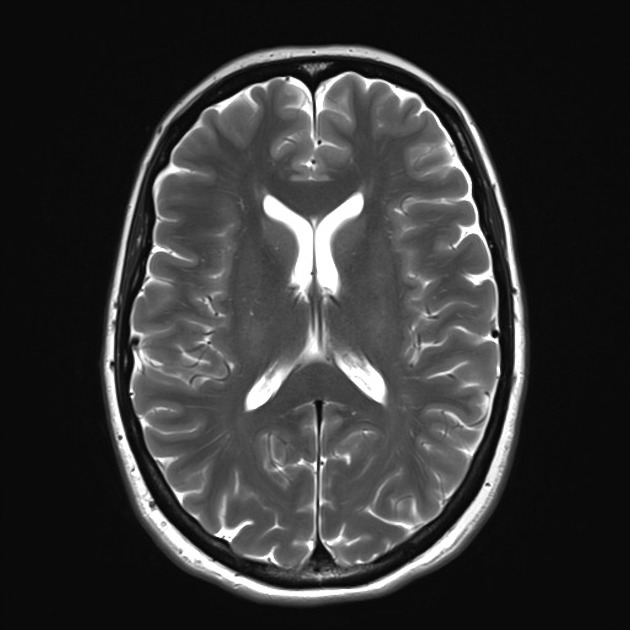

In [44]:
# On charge un exemple d'IRM cérébral
brain = Image.open("brain_mri.jpeg")
brain

In [58]:
brain_array = np.array(brain)
brain_fourier = np.fft.fft2(brain_array) # Transformée de Fourier 2D (=données acquises en pratique)
brain_fourier_shift = np.fft.fftshift(brain_fourier) # Mise au centre des coordonnées nulles
brain_fourier_powerspect = np.abs(brain_fourier_shift) ** 2

Reconstruction error:  0.0


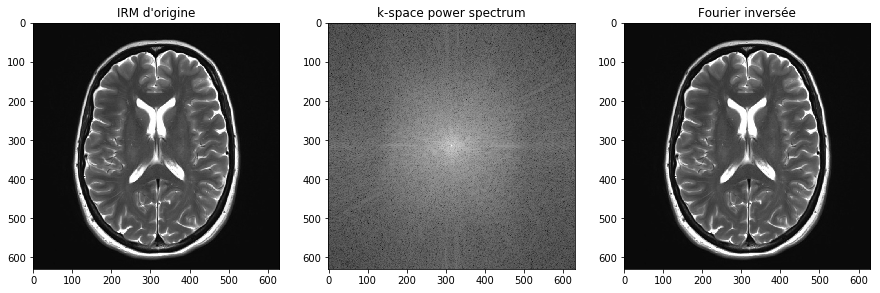

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.array(brain), cmap='gray')
ax[0].set_title('IRM d\'origine')
ax[1].imshow(np.log10(brain_fourier_powerspect.real), cmap='gray')
ax[1].set_title('k-space power spectrum')
ax[2].imshow(np.fft.ifft2(brain_fourier).real, cmap='gray')
ax[2].set_title('Fourier inversée');

error = np.abs(np.linalg.norm(brain) - np.linalg.norm(np.fft.ifft2(brain_fourier_shift))) / np.linalg.norm(brain)
print('Reconstruction error: ', error)

On voit bien que le signal semble sparse dans le $k$-space. Pour nous assurer de la cohérence de notre démarche jusqu'ici, nous observons bien une reconstruction identique à l'image d'origine en prenant la transformée de Fourier inverse. Voyons maintenant ce qu'il se passe si on sous-échantillonne des colonnes de la matrice des signaux dans le $k$-space aléatoirement. Il existe plusieurs schémas de sous-échantillonage; nous nous intéressons ici d'abord au cas le plus simple, qui est celui de colonnes parallèles.

Reconstruction error:  0.00517995721388


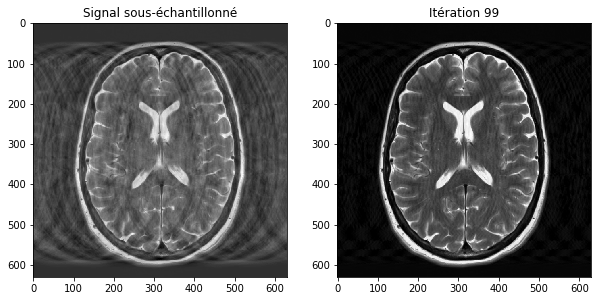

In [66]:
l = 3.
n_iter = 100

brain_under = np.zeros(brain_fourier.shape, dtype='complex')

p = 0.70 # Pourcentage de coefficients conservés
np.random.seed(42)
mask = np.random.binomial(1, p, size=brain_fourier.shape[0], ).astype(np.bool)
brain_under[:,mask] = brain_fourier_shift[:,mask]
brain_under = np.fft.ifftshift(brain_under)
brain_rec = np.fft.ifft2(brain_under)

Y = brain_under
Xi = Y

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, l)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y
    
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(brain_rec.real, cmap='gray')
    ax[0].set_title('Signal sous-échantillonné')
    ax[1].imshow(xi.real, cmap='gray')
    ax[1].set_title('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(brain) - np.linalg.norm(xi)) / np.linalg.norm(brain)
print('Reconstruction error: ', error)